# `starskøpe`

$\phi$**Cyberoptic Telescope for Classifying Astrophysical Phenomena and Finding Planet X**

> Flatiron School Capstone Project
* `Ru Keïn`
* `Instructor: James Irving PhD`
* `Data Science Full-Time Program`
* `Blog post URL:` Exoplanet Hunting with Deep Boltzman Machines
* `Non-Technical Presentation`

# Research Map

## FIRST
What is the best way to classify exoplanetary signals?

## SECOND
Can it be done accurately and reliably using only one type of data? EG timeseries-flux or 1D lightcurve analysis?

## THIRD
How much more accurate/reliable would our algorithm be if:
1) training data includes both "LEFT-BRAIN" and "RIGHT-BRAIN" modes of thinking;
2) training data includes information that requires analytical processing using both patterns of thought, 
but each input is a meshed layering into one projected image.

## NOW
For now, we must first take care of the basics and begin working with the most barebones, minimal dataset we can find: the Kepler labeled Time Series data found on Kaggle. 

# Import

In [1]:
# Import code packages and libraries
# FLATIRON BOOTCAMP Package Library
#!pip install -U fsds_100719
import fsds_100719 as fs
from fsds_100719.imports import * # will pre-load pd,np,plt,mpl,sns
%matplotlib inline
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-bright')


font_dict={'family':'"Titillium Web", monospace','size':16}
mpl.rc('font',**font_dict)
#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')
# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

fsds_1007219  v0.7.16 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
import scipy.ndimage 
import xgboost as xget
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import accuracy_score,roc_curve,auc,average_precision_score, \
recall_score,precision_score,f1_score,classification_report
from sklearn.tree import export_graphviz 
from pydotplus import graph_from_dot_data
from imblearn.over_sampling import SMOTE #For imbalanced datasets
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Uncomment below to install
# !pip install keras
# !pip install tensorflow
# import additional libraries for performing Keras model

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import roc_curve, roc_auc_score
# from scipy.ndimage.filters import uniform_filter1d

# import random
# from keras.utils.np_utils import to_categorical
# from sklearn import preprocessing
# from keras.preprocessing.text import Tokenizer
# from keras import models, layers, optimizers

# from keras.models import Sequential, Model
# from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
# BatchNormalization, Input, concatenate, Activation
# from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
# # astro.py for extremely useful astronomical tools
# # uncomment items below to install 

# !pip install astropy astroquery
# !pip install astropy spectral-cube
# !pip install astropy reproject

## DATASET #1: Kepler Labeled Timeseries

SOURCE: KAGGLE.COM

While most of the datasets we're interested in analyzing exist on the MAST website and are available via API on AWS (as of Feb 20, 2020) - we're going to start off by working with a relatively small subsample of observations  that are primed for machine learning. 


### ( i ) Preliminary Objectives

> 1. Convert and combine Kaggle TRAIN and TEST datasets to Timeseries with astronomical units BJD / PDCSAP_Flux
   
       a) Replace index column with Timeseries values
       b) Each row will is unique time stamp beginning with K2's Campaign 3 start date in UTM units
       c) create DF of 42 confirmed exoplanet host stars since these will be easy to lookup with the MAST API. 
       d) Convert Time stamps to Julian Day units using Astropy library
       e) For each row (observation), convert each flux column name to timestamp (total time is 30 min cadence)
       f) Merge datasets and label remaining observations (same as above)

### ( ii ) Primary Objectives

> 2. Perform Calculations for Normalization, Scaling, Coordinate Mapping and Autoencoding

        a) Create function for identifying Period, Frequency, Amplitude, Ang Momentum, Ang Velocity, Power
        b) Run on all observations and save to new DF with matching Timestamp index as primary key
        c) Validate with the confirmed planets data by doing Astroquery lookup in MAST API

> 4. Data Augmentation and Autoencoding: Fold/Transform Timeseries into frequency domain with Fourier Analysis

        a) Identify harmonic coefficients for each observation with periodic wave attributes (FFT)
        b) FFT Phase shift
        c) Map fourier coefficients as coordinates for autoencoding TCEs
        c) Normalize the FLUX units for each observation (all vals between 0 and 1)
       

> 5. MODELING: 
        
        a) Train-test split (using K-fold Base Split since these are highly imbalanced classes)
        b) Perform initial Machine Learning models with Gridsearch 
            > Support Vector Machines
            > PCA
            > Decision Trees
            > Random Forests
            > Logistic Regression
            > Gradient Descent
            > XGBoost

> 6. Cross-Validation Scoring : assess accuracy of model(s)
- F1 (Harmonic Mean)
- Jaccard Index/Distance
- Fowlkes-Mallows

### (iii) Final Objectives

> 7. Autoencoders for Timeseries data: use Fourier trick to test model with additional K2 campaigns

### (iv) Starskøpe v2 Planned Objectives:

> 8. Computer Vision Unsupervised Model pre-trained with Harmonic Coordinates Autoencoders
  * FITS direct imaging analysis - use coordinates to find matching datasets from TESS

> 9. Deep Boltzman Machines : 
  * extrapolate Fourier-based frequency encodings from above as pre-training stage and combine with TESS / FITs computer vision pattern recognition to train computer vision based model.


According to Mikulski archive website (MAST) where this dataset originated: 

### TIMELINE 

    * the duration of each K2 campaign was ~80 days 
    * Campaign 3 duration was only 69.2 days--it ended earlier than expected because 
      the on-board storage filled up faster than anticipated due to poorer than expected data compression. 
      [SOURCE: https://keplerscience.arc.nasa.gov/k2-data-release-notes.html#k2-campaign-3]
      
    * Campaign 3 began: Nov 15 2014 at 15:06:05
    * Campaign 3 ended: Jan 23 2015 18:37:04
    
    
### DATA MODES/TYPES

Kepler and K2 had three data modes:

    * long cadence (30 min) TPFs
    * short cadence (1 min) postage stamps (TPFs)
    * quarterly FFIs (30 min)
    
    * Each light curve observation is based on ~29.4 min exposure

# TIMESERIES

`Timeseries` : class representing a time series as a collection of values at specific points in time. 

`BinnedTimeSeries` : time series sub-class representated as measurements in discrete time bins

* CREATE, BIN, ADD, READ, WRITE

* ACCESS, EXTRACT, CONVERT, FORMAT

* COMBINE, SORT, RESAMPLE, FOLD

* MASK VALUES
* PANDAS DF
* ESTIMATE PERDIOD (Lomb-SCargle, BLS)

In [4]:
# retrieve a FITS file containing a Kepler light curve for a source:
from astropy.timeseries import TimeSeries
from astropy.utils.data import get_pkg_data_filename
example_data = get_pkg_data_filename('timeseries/kplr010666592-2009131110544_slc.fits')
kepler = TimeSeries.read(example_data, format='kepler.fits')

In [5]:
import numpy as np
from astropy import units as u
from astropy.timeseries import aggregate_downsample
kepler_binned = aggregate_downsample(kepler, time_bin_size=20 * u.min, aggregate_func=np.nanmedian)

Text(0, 0.5, 'SAP Flux (e-/s)')

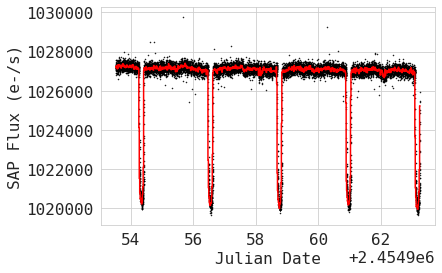

In [6]:
import matplotlib.pyplot as plt
plt.plot(kepler.time.jd, kepler['sap_flux'], 'k.', markersize=1)
plt.plot(kepler_binned.time_bin_start.jd, kepler_binned['sap_flux'], 'r-', drawstyle='steps-pre')
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

Text(0, 0.5, 'SAP Flux (e-/s)')

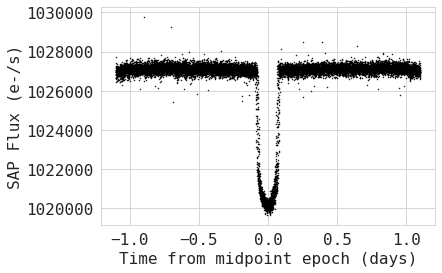

In [7]:
kepler_folded = kepler.fold(period=2.2 * u.day, epoch_time='2009-05-02T20:53:40')

plt.plot(kepler_folded.time.jd, kepler_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time from midpoint epoch (days)')
plt.ylabel('SAP Flux (e-/s)')

Text(0, 0.5, 'Normalized flux')

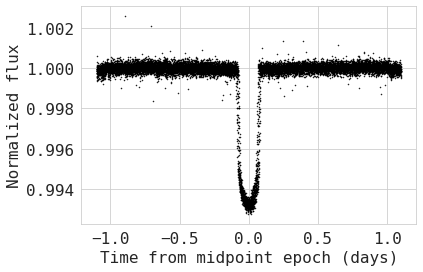

In [8]:
from astropy.stats import sigma_clipped_stats

mean, median, stddev = sigma_clipped_stats(kepler_folded['sap_flux'])

kepler_folded['sap_flux_norm'] = kepler_folded['sap_flux'] / median

plt.plot(kepler_folded.time.jd, kepler_folded['sap_flux_norm'], 'k.', markersize=1)
plt.xlabel('Time from midpoint epoch (days)')
plt.ylabel('Normalized flux')

## Light Curve

1. read in a time series
2. access the data
3. explore and analyze

In [9]:
# retrieve a FITS file containing a Kepler light curve for a source:
from astropy.utils.data import get_pkg_data_filename
filename = get_pkg_data_filename('timeseries/kplr010666592-2009131110544_slc.fits')

In [10]:
from astropy.timeseries import TimeSeries
ts = TimeSeries.read(filename, format='kepler.fits') 

In [11]:
ts

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2009-05-02T00:41:40.338,6.630610e-04,5500,1.0270451e+06,1.4041933e+02,3.7480554e+03,2.2283568e+00,1.0346376e+06,2.4780812e+02,0,nan,nan,nan,nan,1041.56040,1.3623475e-04,613.47997,1.7336856e-04,1.5822421e-03,-1.4463664e-03
2009-05-02T00:42:39.188,6.630857e-04,5501,1.0271844e+06,1.4042902e+02,3.7491572e+03,2.2283657e+00,1.0347789e+06,2.4594159e+02,0,nan,nan,nan,nan,1041.55834,1.3624557e-04,613.48164,1.7334183e-04,1.5743829e-03,-1.4540013e-03
2009-05-02T00:43:38.045,6.631103e-04,5502,1.0270762e+06,1.4038968e+02,3.7502588e+03,2.2283745e+00,1.0346701e+06,2.4408449e+02,0,nan,nan,nan,nan,1041.55751,1.3616899e-04,613.47866,1.7328140e-04,1.5665225e-03,-1.4616371e-03
2009-05-02T00:44:36.894,6.631350e-04,5503,1.0271414e+06,1.4042482e+02,3.7513606e+03,2.2283831e+00,1.0347365e+06,2.4229922e+02,0,nan,nan,nan,nan,1041.55898,1.3622017e-04,613.47947,1.7331526e-04,1.5586632e-03,-1.4692718e-03
2009-05-02T00:45:35.752,6.631597e-04,5504,1.0271569e+06,1.4039404e+02,3.7524626e+03,2.2283916e+00,1.0347527e+06,2.4051416e+02,0,nan,nan,nan,nan,1041.55705,1.3621294e-04,613.48085,1.7329821e-04,1.5508028e-03,-1.4769078e-03
2009-05-02T00:46:34.601,6.631844e-04,5505,1.0272296e+06,1.4043083e+02,3.7535642e+03,2.2284005e+00,1.0348268e+06,2.3879796e+02,0,nan,nan,nan,nan,1041.55916,1.3619773e-04,613.47844,1.7329390e-04,1.5429436e-03,-1.4845425e-03
2009-05-02T00:47:33.451,6.632091e-04,5506,1.0273199e+06,1.4040657e+02,3.7546660e+03,2.2284091e+00,1.0349186e+06,2.3708369e+02,0,nan,nan,nan,nan,1041.55680,1.3621902e-04,613.47908,1.7324935e-04,1.5350844e-03,-1.4921773e-03
2009-05-02T00:48:32.291,6.632337e-04,5507,1.0271497e+06,1.4042722e+02,3.7557673e+03,2.2284179e+00,1.0347472e+06,2.3542677e+02,0,nan,nan,nan,nan,1041.55869,1.3619712e-04,613.47893,1.7332737e-04,1.5272264e-03,-1.4998110e-03


In [12]:
ts['sap_flux'] 

<Quantity [1027045.06, 1027184.44, 1027076.25, ..., 1025451.56, 1025468.5 ,
           1025930.9 ] electron / s>

In [13]:
ts['time', 'sap_flux']  

time,sap_flux
,electron / s
object,float32
2009-05-02T00:41:40.338,1.0270451e+06
2009-05-02T00:42:39.188,1.0271844e+06
2009-05-02T00:43:38.045,1.0270762e+06
2009-05-02T00:44:36.894,1.0271414e+06
2009-05-02T00:45:35.752,1.0271569e+06
2009-05-02T00:46:34.601,1.0272296e+06
2009-05-02T00:47:33.451,1.0273199e+06
2009-05-02T00:48:32.291,1.0271497e+06


In [14]:
ts[0:4]

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2009-05-02T00:41:40.338,6.630610e-04,5500,1.0270451e+06,1.4041933e+02,3.7480554e+03,2.2283568e+00,1.0346376e+06,2.4780812e+02,0,nan,nan,nan,nan,1041.56040,1.3623475e-04,613.47997,1.7336856e-04,1.5822421e-03,-1.4463664e-03
2009-05-02T00:42:39.188,6.630857e-04,5501,1.0271844e+06,1.4042902e+02,3.7491572e+03,2.2283657e+00,1.0347789e+06,2.4594159e+02,0,nan,nan,nan,nan,1041.55834,1.3624557e-04,613.48164,1.7334183e-04,1.5743829e-03,-1.4540013e-03
2009-05-02T00:43:38.045,6.631103e-04,5502,1.0270762e+06,1.4038968e+02,3.7502588e+03,2.2283745e+00,1.0346701e+06,2.4408449e+02,0,nan,nan,nan,nan,1041.55751,1.3616899e-04,613.47866,1.7328140e-04,1.5665225e-03,-1.4616371e-03
2009-05-02T00:44:36.894,6.631350e-04,5503,1.0271414e+06,1.4042482e+02,3.7513606e+03,2.2283831e+00,1.0347365e+06,2.4229922e+02,0,nan,nan,nan,nan,1041.55898,1.3622017e-04,613.47947,1.7331526e-04,1.5586632e-03,-1.4692718e-03


In [15]:
ts.time

<Time object: scale='tdb' format='isot' value=['2009-05-02T00:41:40.338' '2009-05-02T00:42:39.188'
 '2009-05-02T00:43:38.045' ... '2009-05-11T18:05:14.479'
 '2009-05-11T18:06:13.328' '2009-05-11T18:07:12.186']>

In [16]:
ts.time.mjd

array([54953.0289391 , 54953.02962023, 54953.03030145, ...,
       54962.7536398 , 54962.75432093, 54962.75500215])

In [17]:
ts.time.scale # Barycentric Dynamical Time scale

'tdb'

Text(0, 0.5, 'SAP Flux (e-/s)')

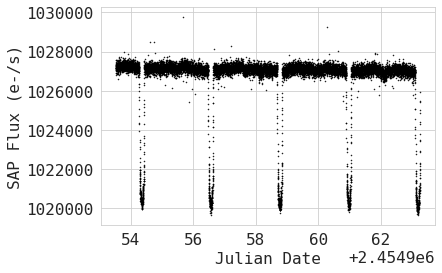

In [18]:
import matplotlib.pyplot as plt
plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

### Estimate Period

In [19]:
#  estimate the period, using the ‘box least squares’ (BLS) algorithm:
import numpy as np
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux') 

In [20]:
periodogram

In [21]:
# periodogram analysis: use box duration of 0.2 days:

results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]  
period  

transit_time = results.transit_time[best]  
transit_time  

<Time object: scale='tdb' format='isot' value=2009-05-02T20:51:16.338>

In [22]:
# fold time series using period we just identified
ts_folded = ts.fold(period=period, epoch_time=transit_time)  

Text(0, 0.5, 'SAP Flux (e-/s)')

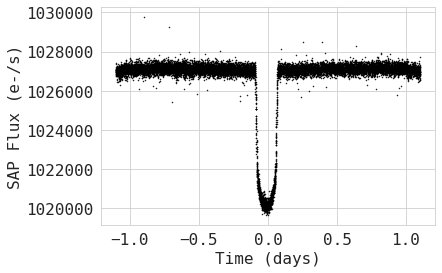

In [23]:
plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

### Normalize

normalize the flux by sigma-clipping the data to determine the baseline flux

In [24]:
from astropy.stats import sigma_clipped_stats
mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])  
ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median  

### Binning
downsample the time series by binning the points into bins of equal time - this returns a BinnedTimeSeries:

In [25]:
from astropy.timeseries import aggregate_downsample
ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.03 * u.day)  
ts_binned 

time_bin_start,time_bin_size,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,sap_flux_norm
,s,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,
object,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-1.1022116370482966,2592.0,0.0008528293110430241,13195,1026973.3125,140.15341186523438,3746.68212890625,2.2319154739379883,1034719.25,159.33334350585938,186,nan,nan,nan,nan,1041.5578111888517,0.0001344159827567637,613.4819883877723,0.00017141240823548287,0.0009826311143115163,0.00031207725987769663,0.9998741745948792
-1.0722116370482966,2592.0,0.0008550441125407815,13285,1027007.4375,140.14646911621094,3753.750244140625,2.231780767440796,1034757.6875,157.7557373046875,377,nan,nan,nan,nan,1041.5577504134303,0.00013433954154606909,613.4822167745142,0.00017133924120571464,0.0009682553354650736,0.00041217938996851444,0.9999074339866638
-1.0422116370482966,2592.0,0.0008565832395106554,13347,1027074.6875,140.15179443359375,3748.86181640625,2.2302093505859375,1034825.75,157.19195556640625,188,nan,nan,nan,nan,1041.5577686511494,0.00013433014100883156,613.4820760574382,0.0001713316742097959,0.0009710012236610055,0.00039273229776881635,0.999972939491272
-1.0122116370482965,2592.0,0.0008569943020120263,13364,1027110.5625,140.14944458007812,3738.2421875,2.2315773963928223,1034864.1875,157.39439392089844,145,nan,nan,nan,nan,1041.557653652237,0.0001343248732155189,613.482021759561,0.00017132052744273096,0.0008492720662616193,0.0002928022004198283,1.0000077486038208
-0.9822116370482965,2592.0,0.0008580777212046087,13408,1027094.5625,140.14981079101562,3725.346923828125,2.229959726333618,1034849.625,156.60211181640625,239,nan,nan,nan,nan,1041.5576283032685,0.00013433363346848637,613.4820869230539,0.00017133451183326542,0.0008298085886053741,0.0003891147789545357,0.9999921917915344
-0.9522116370482965,2592.0,0.0008591610821895301,13452,1027113.0625,140.15042114257812,3734.561767578125,2.232150077819824,1034865.4375,156.15545654296875,157,nan,nan,nan,nan,1041.5575716567903,0.00013432394189294428,613.4820772320006,0.0001713206002023071,0.0007625969010405242,0.0003491091774776578,1.0000101327896118
-0.9222116370482966,2592.0,0.0008602443849667907,13496,1027115.0625,140.15025329589844,3727.908447265625,2.2327475547790527,1034873.1875,155.09400939941406,206,nan,nan,nan,nan,1041.557550072349,0.00013432576088234782,613.4819781207854,0.00017131913045886904,0.0007079299539327621,0.0002824827388394624,1.0000121593475342
-0.8922116370482965,2592.0,0.0008613277459517121,13540,1027092.9375,140.14971923828125,3662.0966796875,2.230905532836914,1034847.9375,156.9192352294922,103,nan,nan,nan,nan,1041.5575624043458,0.00013433060667011887,613.481768691082,0.00017132052744273096,0.0007373436819761992,0.00016335179680027068,0.9999905228614807


Text(0, 0.5, 'Normalized flux')

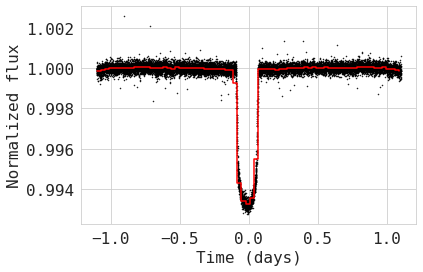

In [26]:
plt.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
plt.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], 'r-', drawstyle='steps-post')
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')

## Initialize Timeseries

In [27]:
from astropy import units as u
from astropy.timeseries import TimeSeries
ts1 = TimeSeries(time_start='2016-03-22T12:30:31',
                 time_delta=3 * u.s,
                 n_samples=5)
ts1

time
object
2016-03-22T12:30:31.000
2016-03-22T12:30:34.000
2016-03-22T12:30:37.000
2016-03-22T12:30:40.000
2016-03-22T12:30:43.000


# Matching Kaggle Labeled Datasets to MAST API dataset

    Pointing
    RA: 336.66534641439 degrees
    Dec: -11.096663792177 degrees
    Roll: -158.494818065985 degrees

    Targets With Data Available at MAST
    16,833 EPIC IDs in long cadence (LC).
    216 EPIC IDs in short cadence (LC).
    Several custom targets (see below)

    Full Frame Images (FFI)
    ktwo2014331202630-c03_ffi-cal.fits
    ktwo2015008010551-c03_ffi-cal.fits

    First cadence
    Time: 2014-11-15 14:06:05.515 UTC
    Long Cadence Number: 99599
    Short Cadence Number: 2976430

    Last cadence
    Time: 2015-01-23 18:37:04.488 UTC
    Long Cadence Number: 102984
    Short Cadence Number: 3078009
    Most Recent Processing Version
    Data Release 26

In [28]:
from astropy import units as u
from astropy.timeseries import TimeSeries
ts1 = TimeSeries(time_start='2016-03-22T12:30:31',
                 time_delta=3 * u.s,
                 n_samples=5)


In [29]:
# from astropy.table import vstack
# from astropy import units as u
# from astropy.timeseries import TimeSeries
# ts_a = TimeSeries(time_start='2014-11-15T15:06:05'
#                   time_delta=3 * u.s,
#                   data={'flux': [1, 4, 5, 3, 2] * u.mJy})
# ts_b = TimeSeries(time_start='2016-03-22T12:50:31',
#                   time_delta=3 * u.s,
#                   data={'flux': [4, 3, 1, 2, 3] * u.mJy})
# ts_ab = vstack([ts_a, ts_b])
# ts_ab

# from astropy.table import Table, hstack
# data = Table(data={'flux': [40., 41., 40., 39., 30.] * u.K})
# ts_a_data = hstack([ts_a, data])
# ts_a_data



# from astropy.table import Table, hstack
# data = Table(data={'flux': [40., 41., 40., 39., 30.] * u.K})
# ts_a_data = hstack([ts_a, data])
# ts_a_data

In [30]:
import cufflinks as cf
cf.go_offline()

In [31]:
train = pd.read_csv('DATA/exoTrain.csv')
test = pd.read_csv('DATA/exoTest.csv')

In [32]:
display(train.head(), test.head())

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,FLUX.42,FLUX.43,FLUX.44,FLUX.45,FLUX.46,FLUX.47,FLUX.48,FLUX.49,FLUX.50,FLUX.51,...,FLUX.3146,FLUX.3147,FLUX.3148,FLUX.3149,FLUX.3150,FLUX.3151,FLUX.3152,FLUX.3153,FLUX.3154,FLUX.3155,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,-195.99,-208.31,-103.22,-193.85,-187.64,-92.25,-119.25,-87.50,-1.86,-4.99,18.01,11.12,...,-178.96,-20.76,101.27,2.15,-6.04,-58.44,-29.64,-90.71,-90.71,-265.25,-367.84,-317.51,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,-24.68,-27.62,-31.21,-32.31,-37.52,-46.58,-46.20,-35.79,-42.09,-51.25,-46.61,-33.67,...,-25.49,-18.72,18.75,5.10,17.57,-16.46,21.43,-32.67,-32.67,-58.56,-51.99,-32.14,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,224.02,237.69,251.53,236.06,212.31,220.95,249.08,234.14,259.02,280.05,269.55,283.48,...,-62.94,-75.98,-33.38,-45.09,-50.22,-97.19,-64.22,-123.17,-123.17,-144.86,-106.97,-56.38,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,70.31,63.67,75.00,70.73,70.29,95.44,100.57,114.93,103.45,107.80,115.08,105.44,...,-16.97,24.42,-16.04,-18.86,-11.27,-19.92,-1.99,-13.49,-13.49,-27.74,-30.46,-32.40,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.1

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,FLUX.42,FLUX.43,FLUX.44,FLUX.45,FLUX.46,FLUX.47,FLUX.48,FLUX.49,FLUX.50,FLUX.51,...,FLUX.3146,FLUX.3147,FLUX.3148,FLUX.3149,FLUX.3150,FLUX.3151,FLUX.3152,FLUX.3153,FLUX.3154,FLUX.3155,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,-23.17,-29.26,-33.99,-6.25,-28.12,-27.24,-32.28,-12.29,-16.57,-23.86,-5.69,9.24,35.52,81.20,116.49,133.99,148.97,174.15,187.77,215.30,246.80,-56.68,-56.68,-56.68,-52.05,-31.52,-31.15,-48.53,-38.93,-26.06,6.63,29.13,64.70,79.74,12.21,12.21,-19.94,-28.60,-20.54,51.39,22.06,...,9.23,2.08,14.70,-11.44,-21.86,-16.38,-7.24,22.69,22.69,7.10,3.45,6.49,-2.55,12.26,-7.06,-23.53,2.54,30.21,38.87,-22.86,-22.86,-4.37,2.27,-16.27,-30.84,-7.21,-4.27,13.60,15.62,31.96,49.89,86.93,86.93,42.99,48.76,22.82,32.79,30.76,14.55,10.92,22.68,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,5329.39,5191.38,5031.39,4769.89,4419.66,4218.92,3924.73,3605.30,3326.55,3021.20,2800.61,2474.48,2258.33,1951.69,1749.86,1585.38,1575.48,1568.41,1661.08,1977.33,2425.62,2889.61,3847.64,3847.64,3741.20,3453.47,3202.61,2923.73,2694.84,2474.22,2195.09,1962.83,1705.44,1468.27,3730.77,3730.77,3833.30,3822.06,3803.47,3813.12,3726.64,...,427.80,61.86,-422.34,-971.42,-1327.75,-1864.69,-2148.34,1166.45,1166.45,934.66,574.19,-216.31,-3470.75,-4510.72,-5013.41,-3636.05,-2324.27,-2688.55,-2813.66,-586.22,-586.22,-756.80,-1090.23,-1388.61,-1745.36,-2015.28,-2359.06,-2516.66,-2699.31,-2777.55,-2732.97,1167.39,1167.39,1368.89,1434.80,1360.75,1148.44,1117.67,714.86,419.02,57.06,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,85.49,-20.12,-35.88,-65.59,-15.12,16.60,-25.70,61.88,53.18,64.32,72.38,100.35,67.26,14.71,-16.41,-147.46,-231.27,-320.29,-407.82,-450.48,-146.99,-146.99,-146.99,-146.99,-166.30,-139.90,-96.41,-23.49,13.59,67.59,32.09,76.65,58.30,5.41,61.66,61.66,126.79,20.80,-16.95,13.37,-24.29,...,-74.91,9.95,-42.54,-28.46,-38.15,-61.43,-127.18,-12.15,-12.15,-80.84,-112.96,-129.34,-35.24,-70.13,-35.30,-56.48,-74.60,-115.18,-8.91,-37.59,-37.59,-37.43,-104.23,-101.45,-107.35,-109.82,-126.27,-170.32,-117.85,-32.30,-70.18,314.29,314.29,314.29,149.71,54.60,12.60,-133.68,-78.16,-52.30,-8.55,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,-706.03,-720.56,-631.12,-659.16,-672.03,-665.06,-667.94,-660.84,-672.75,-644.91,-680.53,-620.50,-570.34,-530.00,-537.88,-578.38,-532.34,-532.38,-491.03,-485.03,-427.19,-380.84,-329.50,-286.91,-283.81,-298.19,-271.03,-268.50,-209.56,-180.44,-136.25,-136.22,-68.03,2.88,-732.94,-732.94,-613.06,-591.62,-506.53,-491.91,-459.53,...,139.03,33.22,-3.19,-128.00,-219.88,-247.56,-287.50,-135.41,-135.41,40.19,81.06,110.88,16.50,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-14.94,64.09,8.38,45.31,100.72,91.53,46.69,20.34,30.94,-36.81,-33.28,-69.62,-208.00,-280.28,-340.41,-337.41,-268.03,-245.00,-230.62,-129.59,-35.47,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,

# Scrub

In [33]:
display(train.shape,test.shape)

(5087, 3198)

(570, 3198)

In [34]:
# checking for imbalanced classes
display(train['LABEL'].value_counts(),test['LABEL'].value_counts())

1    5050
2      37
Name: LABEL, dtype: int64

1    565
2      5
Name: LABEL, dtype: int64

In [35]:
train.isna().sum().value_counts()

0    3198
dtype: int64

In [36]:
test.isna().sum().value_counts()

0    3198
dtype: int64

# Explore

## Compare: Exoplanet vs Non-exoplanet Host Stars

In [42]:
# look at the first Star in the dataset (label = 2 means confirmed host of exoplanet)
star0 = train.iloc[0, :]
star0.head()

LABEL      2.00
FLUX.1    93.85
FLUX.2    83.81
FLUX.3    20.10
FLUX.4   -26.98
Name: 0, dtype: float64

In [38]:
# look at the last Star in the dataset (label = 1 means NOT a confirmed exoplanet host)
star5086 = train.iloc[-1, :]
star5086.head()

LABEL       1.00
FLUX.1    323.28
FLUX.2    306.36
FLUX.3    293.16
FLUX.4    287.67
Name: 5086, dtype: float64

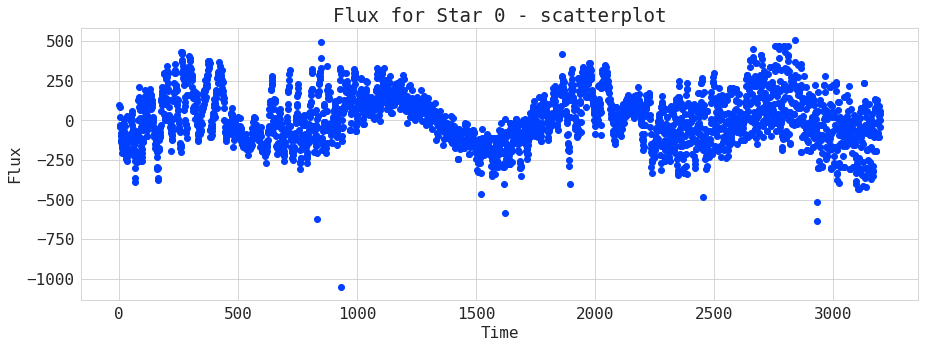

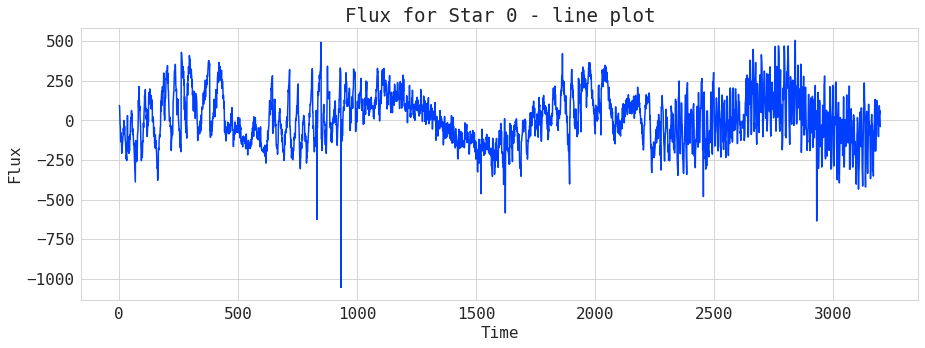

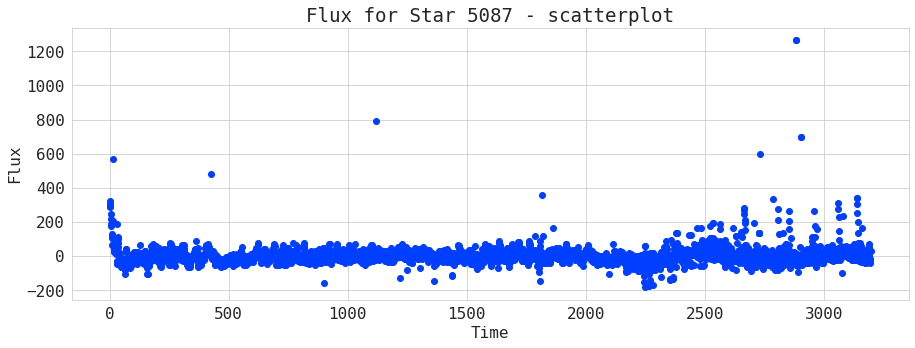

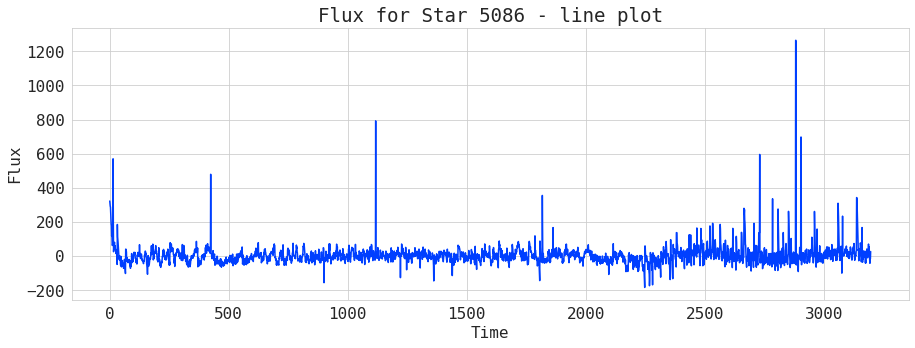

In [39]:
# Scatter Plot For First Star
plt.figure(figsize=(15, 5))
plt.scatter(pd.Series([i for i in range(1, len(star0))]), star0[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for Star 0 - scatterplot')
plt.show()

# Line Plot For First Star
plt.figure(figsize=(15, 5))
plt.plot(pd.Series([i for i in range(1, len(star0))]), star0[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for Star 0 - line plot')
plt.show()


# Scatter Plot For Last Star
plt.figure(figsize=(15, 5))
plt.scatter(pd.Series([i for i in range(1, len(star5086))]), star5086[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for Star 5087 - scatterplot')
plt.show()

# Line Plot For last Star
plt.figure(figsize=(15, 5))
plt.plot(pd.Series([i for i in range(1, len(star5086))]), star5086[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for Star 5086 - line plot')
plt.show()

## Closer Look: Exoplanet Host Star

In [43]:
#X_star0 = star0.drop(columns='LABEL', axis=1, inplace=True)
flux = star0.copy()
flux.index


Index(['LABEL', 'FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6',
       'FLUX.7', 'FLUX.8', 'FLUX.9',
       ...
       'FLUX.3188', 'FLUX.3189', 'FLUX.3190', 'FLUX.3191', 'FLUX.3192',
       'FLUX.3193', 'FLUX.3194', 'FLUX.3195', 'FLUX.3196', 'FLUX.3197'],
      dtype='object', length=3198)

In [45]:

# flux = star0.drop(labels=['LABEL','FLUX.3197','FLUX.3196'])
# flux

In [51]:
flux = star0.drop(labels=['LABEL'])
flux

FLUX.1       93.85
FLUX.2       83.81
FLUX.3       20.10
FLUX.4      -26.98
FLUX.5      -39.56
             ...  
FLUX.3193    92.54
FLUX.3194    39.32
FLUX.3195    61.42
FLUX.3196     5.08
FLUX.3197   -39.54
Name: 0, Length: 3197, dtype: float64

In [64]:
x = np.array(flux)

TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

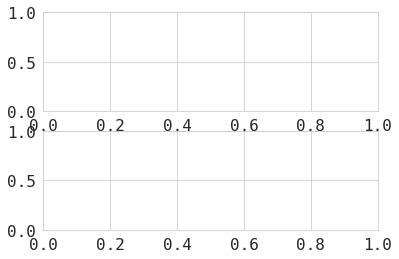

In [73]:
import matplotlib.pyplot as plt
import numpy as np
NFFT = 500  # the length of the windowing segments
Fs = 500  #int(1.0 / dt)  # the sampling frequency
pad_to = 3000
# dt = 0.0005
# t = np.arange( dt)

fig, (ax1, ax2) = plt.subplots(nrows=2)
# ax1.plot(t, x)
Pxx, freqs, bins, im = plt.specgram(x, pad_to=3000, NFFT=NFFT)

TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

In [54]:
dt = 0.0005
t = np.arange(0.0, 20.0, dt)
s1 = np.sin(2 * np.pi * 100 * t)
s2 = 2 * np.sin(2 * np.pi * 400 * t)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

dt = 0.0005
t = np.arange(0.0, 20.0, dt)
s1 = np.sin(2 * np.pi * 100 * t)
s2 = 2 * np.sin(2 * np.pi * 400 * t)

# create a transient "chirp"
s2[t <= 10] = s2[12 <= t] = 0

# add some noise into the mix
nse = 0.01 * np.random.random(size=len(t))

x = s1 + s2 + nse  # the signal
NFFT = 1024  # the length of the windowing segments
Fs = int(1.0 / dt)  # the sampling frequency

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(t, x)
Pxx, freqs, bins, im = ax2.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()

In [ ]:
# Get index of Maximum flux value
idx_peak = np.nanargmax(star0)
idx_peak

In [ ]:
f_peak = star0[idx_peak]
f_peak

In [ ]:
#X_star0 = star0.drop(columns='LABEL', axis=1, inplace=True)
X_star0 = star0.copy()
X_star0.index

In [ ]:
X_star0.shape

In [ ]:
X_star0 = X_star0.drop(labels=['LABEL','FLUX.3197','FLUX.3196'])
X_star0

In [ ]:
3195/9 # 355

In [ ]:
X_star0 = np.array(X_star0)
X_star0

In [ ]:

import pandas as pd
from astropy.table import QTable
import astropy.units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord

In [ ]:
# Astronomic Unit Conversion and Time Series Manipulation Helper Packages
import logging
import sys
import os
import warnings

from astropy.visualization import (PercentileInterval, ImageNormalize,
                                   SqrtStretch, LinearStretch)
from astropy.time import Time

from astropy.table import vstack, hstack, Table
from astropy import units as u
from astropy.timeseries import TimeSeries

#bkjd_to_astropy_time(bkjd, bjdref=2454833.)
# bkjd = np.atleast_1d(bkjd)
# jd = bkjd + bjdref
# # Some data products have missing time values;
# # we need to set these to zero or `Time` cannot be instantiated.
# jd[~np.isfinite(jd)] = 0
# if isinstance(bkjd, float):  # If user entered a float, return a float
#     jd = jd[0]
# return Time(jd, format='jd', scale='tdb')



# def bkjd_to_astropy_time(bkjd, bjdref=2454833.):
#     """Converts Kepler Barycentric Julian Day (BKJD) time values to an
#     `astropy.time.Time` object.

#     Kepler Barycentric Julian Day (BKJD) is a Julian day minus 2454833.0
#     (UTC=January 1, 2009 12:00:00) and corrected to the arrival times
#     at the barycenter of the Solar System.
#     BKJD is the format in which times are recorded in the Kepler data products.
#     The time is in the Barycentric Dynamical Time frame (TDB), which is a
#     time system that is not affected by leap seconds.
#     See Section 2.3.2 in the Kepler Archive Manual for details.

#     Parameters
#     ----------
#     bkjd : float or array of floats
#         Barycentric Kepler Julian Day.
#     bjdref : float
#         BJD reference date, for Kepler this is 2454833.

#     Returns
#     -------
#     time : `astropy.time.Time` object
#         Resulting time object.
#     """

In [ ]:
bkjd = np.atleast_1d(bkjd)
jd = bkjd + bjdref
    
Time(jd, format='jd', scale='tdb')
    # np.nanargmax(data)
    
    

In [ ]:
!pip install specviz
# from specviz import specutils
# specutils.analysis.line_flux()

In [ ]:
# Univariate Hermite series.
from astropy.modeling import polynomial

polynomial.Hermitee1D()

In [ ]:
# polynomial.Hermite1D(
#     degree, 
#     domain=None, 
#     window=[-1, 1], 
#     n_models=None, 
#     model_set_axis=None, 
#     name=None, 
#     meta=None, 
#     **params)


# It is defined as:

# 𝑃(𝑥)=∑𝑖=0𝑖=𝑛𝐶𝑖∗𝐻𝑖(𝑥)
# where H_i(x) is the corresponding Hermite polynomial (“Physicist’s kind”).

# Matching Kaggle Labeled Datasets to MAST API dataset

    Pointing
    RA: 336.66534641439 degrees
    Dec: -11.096663792177 degrees
    Roll: -158.494818065985 degrees

    Targets With Data Available at MAST
    16,833 EPIC IDs in long cadence (LC).
    216 EPIC IDs in short cadence (LC).
    Several custom targets (see below)

    Full Frame Images (FFI)
    ktwo2014331202630-c03_ffi-cal.fits
    ktwo2015008010551-c03_ffi-cal.fits

    First cadence
    Time: 2014-11-15 14:06:05.515 UTC
    Long Cadence Number: 99599
    Short Cadence Number: 2976430

    Last cadence
    Time: 2015-01-23 18:37:04.488 UTC
    Long Cadence Number: 102984
    Short Cadence Number: 3078009
    Most Recent Processing Version
    Data Release 26

In [ ]:
#pip install specviz

# # Mean
# astropy.units.Quantity.mean

# # Median:
# numpy.median

# # Std Dev:
# astropy.units.Quantity.std

# # Centroid:
# specutils.analysis.centroid()

# # RMS:
# numpy.sqrt(flux.dot(flux) / len(flux))

# # SNR:
# specutils.analysis.snr()

# # FWHM:
# specutils.analysis.fwhm()

# # Eq Width:
# specutils.analysis.equivalent_width()

# # Max:
# astropy.units.quantity.Quantity.max

# # Min:
# astropy.units.quantity.Quantity.min

# # Count Total:
# specutils.analysis.line_flux()

In [ ]:
# total number of observations: length of N rows (train and test combined)
print(len(train) + len(test)) #5657

# flux values per observation
print(len(train.columns))

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
# since we don't know the units, we'll create a timeseries and assign
# units based on original K2 Long Cadence time intervals from Campaign 3 
# (Note the Exodata dataset includes all values from Campaign 3)

In [ ]:
from astropy.units import cds
cds.enable() 

# spherical_to_cartesian(r, lat, lon)

# Converts spherical polar coordinates to rectangular cartesian coordinates.
# parallax()

# Returns a list of equivalence pairs that handle the conversion between parallax angle and distance.

# spectral()
# Returns a list of equivalence pairs that handle spectral wavelength, wave number, frequency, and energy equivalences.

In [ ]:
input_flux_ex1 = 1e-13 * u.Jy
input_wave_ex1 = 1 * u.micron
abmag_ex1 = input_flux_ex1.to(u.ABmag, u.spectral_density(input_wave_ex1))
print('{:.2f}'.format(abmag_ex1))

In [ ]:
# start date for Campaign 3 in UTC format
tstart = '2014-11-15T15:06:05'
tstart = Time(tstart, scale = 'utc')
print(tstart)

In [ ]:
# # K2 campaign 3 start was Nov 15 2014 at 15:06:05 
idx_train = TimeSeries(time_start='2014-11-15T15:06:05', 
                       time_delta = 30 * u.min, 
                       n_samples = 5087, data={'flux'})
# print(idx_train)

In [ ]:
# K2 campaign 3 start was Nov 15 2014 at 15:06:05 
idx_test = TimeSeries(time_start='2015-01-18T05:12:05',
                      time_delta = 18 * u.min,
                      n_samples = 570)
print(idx_test)

In [ ]:
idx_train.time.mjd

In [ ]:
train['time'] = idx_train.time.mjd
test['time'] = idx_test.time.mjd

In [ ]:
ts_train = train.set_index('time')

In [ ]:
ts_test = test.set_index('time')

In [ ]:
# stack train and test data - we will do our own train-test split later on
k2c3 = ts_train.append(ts_test)

In [ ]:
k2c3

In [ ]:
# Drop last two columns so we can make equally divided frequency folds
k2c3.drop(columns={'FLUX.3196','FLUX.3197'}, axis=1, inplace=True)

In [ ]:
k2c3.shape

In [ ]:
k2c3_y = k2c3['LABEL'].copy()

k2c3_X = k2c3.drop(columns='LABEL', axis=1)

In [ ]:
flux = k2c3.iloc[0,1:]
flux

In [ ]:
flux1 = np.array(flux.iloc[:1065])
# flux2 = flux.iloc[1065:-1065]
# flux3 = flux.iloc[-1065:]
flux1

In [ ]:
max1 = flux1.max()
min1 = flux1.min()
print(max1, min1)

In [ ]:
max2 = flux2.max()
min2= flux2.min()
print(max2,min2)

In [ ]:
max3 = flux3.max()
min3 = flux3.min()
print(max3,min3)

In [ ]:
thirds = np.array(flux).reshape(3,1065)
thirds

In [ ]:
thirds.max(axis=1)

In [ ]:
thirds.min(axis=1)

In [ ]:
thirds.max(axis=1).mean()

In [ ]:
thirds.min(axis=1).mean()

# ƒast ƒourier transform

The routine ``np.fft.fftfreq(n)`` returns an array giving the frequencies
of corresponding elements in the output.  The routine
``np.fft.fftshift(A)`` shifts transforms and their frequencies to put the
zero-frequency components in the middle, and ``np.fft.ifftshift(A)`` undoes
that shift.

--------
    `signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)`
    `fourier = np.fft.fft(signal)`
    `n = signal.size`
    `timestep = 0.1`
    `freq = np.fft.fftfreq(n, d=timestep)`
    `freq`
    `array([ 0.  ,  1.25,  2.5 ,  3.75, -5.  , -3.75, -2.5 , -1.25])`

In [ ]:
# Return the Discrete Fourier Transform sample frequencies.
# The returned float array f contains the frequency bin centers in cycles per unit 
# of the sample spacing (with zero at the start). For instance, if the sample spacing
# is in seconds, then the frequency unit is cycles/second.


# Shift the zero-frequency component to the center of the spectrum.

# This function swaps half-spaces for all axes listed (defaults to all). 
# Note that y[0] is the Nyquist component only if len(x) is even.

# >>> freqs = np.fft.fftfreq(10, 0.1)
# >>> freqs
# array([ 0.,  1.,  2., ..., -3., -2., -1.])

# >>> np.fft.fftshift(freqs)
# array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

# Shift the zero-frequency component only along the second axis:
# >>>
# >>> freqs = np.fft.fftfreq(9, d=1./9).reshape(3, 3)
# >>> freqs
# array([[ 0.,  1.,  2.],
#        [ 3.,  4., -4.],
#        [-3., -2., -1.]])

# >>> np.fft.fftshift(freqs, axes=(1,))
# array([[ 2.,  0.,  1.],
#        [-4.,  3.,  4.],
#        [-1., -3., -2.]])

In [ ]:
signal = np.array(flux)

In [ ]:
fourier = np.fft.fft(signal)
print(fourier)

In [ ]:
plt.plot(fourier);

In [ ]:
n = signal.size
n

In [ ]:
timestep = 0.1

In [ ]:
freq = np.fft.fftfreq(n, d=timestep)
freq

In [ ]:
# Shift the zero-frequency component to the center of the spectrum
zshift = np.fft.fftshift(freq)
print(zshift)

In [ ]:
plt.plot(zshift);

In [ ]:
# Shift the zero-frequency component only along the second axis:
# sig = np.array(thirds)
# n3 = thirds.size #3195
zerofreq = np.fft.fftshift(thirds,axes=(1,))
print(zerofreq)

In [ ]:
plt.plot(freq);

In [ ]:
plt.plot(zerofreq);

In [ ]:
1065/5

In [ ]:
flux[:71]

In [ ]:
signal = np.array(flux1)
n = signal.size
n

In [ ]:
1065/3

In [ ]:
matrix = np.array(flux1).reshape(3,355)
matrix

In [ ]:
# # K2 campaign 3 start was Nov 15 2014 at 15:06:05 
ts = TimeSeries(time_start='2015-01-18T05:12:05',
                    time_delta = .01 * u.s,
                    data={'flux': k2c3_0 * u.Jy})


print(ts)

In [ ]:
ts.time.scale

In [ ]:
flux = ts['flux'].quantity
flux

In [ ]:
flux_arr = np.array(flux)
flux_arr

In [ ]:
# Max:
ind = np.unravel_index(np.argmax(flux_arr), flux_arr.shape, order='F')
ind

In [ ]:
flux_arr[ind]

In [ ]:
# Folding
# The TimeSeries class has a fold() method that can be used to return a new time
# series with a relative and folded time axis. This method takes the period as a 
# Quantity, and optionally takes an epoch as a Time, which defines a zero time 
# offset:

ts_0_folded = ts_0.fold(period=(2*np.pi)
ts_0_folded

In [ ]:
# plt.plot(ts_0_folded.time, ts_0_folded['flux'], 'k.', markersize=1)
# plt.xlabel('Time from midpoint epoch (days)')
# plt.ylabel('SAP Flux (e-/s)')

from astropy.timeseries import aggregate_downsample
ts_0_binned = aggregate_downsample(ts_0, time_bin_size= 10.65 * u.s, aggregate_func=np.nanmedian)

# plt.plot(ts_0.time.utc, ts_0['flux'], 'k.', markersize=1)
# plt.plot(ts_0_binned.time_bin_start.utc, ts_0_binned['flux'], 'r-', drawstyle='steps-pre')
# plt.xlabel('Mod Julian Date')
# plt.ylabel('SAP Flux (e-/s)')

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split()

In [ ]:
# # 


# Min:
astropy.units.quantity.Quantity.min

# 3195/3
# freq1 = np.array(train.iloc[:4])
# freq1.shape
# data = np.array(train)
# data = pd.DataFrame(data)
# print(data)

# row372 = keplerTest.iloc[372,1:]
# row372 = np.array(row372)
# plt.plot(row372)

a = np.mgrid[:3, :3, :3][0]
a
delta_p = delta_t.value * u.day / period

In [ ]:
### from KeplerAI docs on github 



# dataN = NormaliseRows(data, 0, 1)
# dataN = pd.Series(dataN)
# dataN = dataN.values.reshape(4,7)
# dataN = pd.DataFrame(dataN)
# dataN = dataN.iloc[:,1:]
# print(dataN)

# plt.plot(dataN.iloc[0,])
# plt.plot(dataN.iloc[1,])
# plt.plot(dataN.iloc[2,])
# plt.plot(dataN.iloc[3,])

# row124 = keplerTest.iloc[124,1:]
# row124N = np.array(row124)
# plt.plot(row124N)


# row372 = keplerTest.iloc[372,1:]
# row372 = np.array(row372)
# plt.plot(row372)



def NormaliseRows(dataFrame, newMinimum, newMaximum):
    
    dataFrameN = []
    
    for row in dataFrame.itertuples():
        
        rowMin = min(row)
        rowMax = max(row)
        
        for cell in row:
            cellN = (((cell - rowMin) / (rowMax - rowMin)) * (newMaximum - newMinimum)) + newMinimum
            dataFrameN.append(cellN)
    
    return dataFrameN

# k2_0 = NormaliseRows()

In [ ]:

# Given a window length n and a sample spacing d:
# f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
# f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd

# >>> signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
# >>> fourier = np.fft.fft(signal)
# >>> n = signal.size
# >>> timestep = 0.1
# >>> freq = np.fft.fftfreq(n, d=timestep)
# >>> freq
# array([ 0.  ,  1.25,  2.5 , ..., -3.75, -2.5 , -1.25])


signal = np.array(star0, dtype=float)
ƒ = np.fft.fft(signal)

n = signal.size
timestep=.1
freq = np.fft.fftfreq(n, d=timestep)
freq

In [ ]:
plt.plot(freq);

In [ ]:
ƒ

In [ ]:
plt.plot(ƒ);

In [ ]:
signal

In [ ]:
j = np.conj(ƒ.T) - signal
j

In [ ]:
plt.plot(j);

In [ ]:
freq_spectrum = np.fft.hfft(ƒ)

In [ ]:
freq_spectrum

In [ ]:
plt.plot(freq_spectrum);

In [ ]:
arr = np.array(star0)
arr

In [ ]:
freqs = np.arange(arr.size/2+1, dtype=float)
freqs

In [ ]:
plt.plot(freqs);

In [ ]:
# Scatter Plot For First Star
plt.figure(figsize=(15, 5))
#plt.scatter(pd.Series([i for i in range(1, len(star0))]), star0[1:])
plt.plot(pd.Series([i for i in range(1, len(freqs))]), freqs[1:], color='r',alpha=.5)
plt.plot(pd.Series([ƒ for ƒ in ƒ]))
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for Star 0 - scatterplot')
plt.show()

In [ ]:


from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file
from astropy.utils import data
data.conf.remote_timeout = 60
from spectral_cube import SpectralCube
from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
# from reproject import reproject_interp


In [ ]:
# https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblSearch/nph-tblSearchInit?app=ExoTbls&config=k2targets

from astroquery.mast import Observations
print(Observations.list_missions())


# ['BEFS', 'EUVE', 'FUSE', 'GALEX', 'HLA', 'HLSP', 'HST', 'HUT', 'IUE', 'JWST', 
# 'K2', 'K2FFI', 'Kepler', 'KeplerFFI', 'PS1', 'SPITZER_SHA', 'SWIFT', 'TESS', 
# 'TUES', 'WUPPE']


meta_table = Observations.get_metadata("observations")
print(meta_table[:5])


Observations.query_region()

In [ ]:
# Converting times
# `astropy.time <http://docs.astropy.org/en/stable/time/index.html>`__ provides methods to convert times and dates between different systems and formats. Since the ESO FITS headers already contain the time of the observation in different systems, we could just read the keyword in the time system we like, but we will use astropy.time to make this conversion here. astropy.time.Time will parse many common input formats (strings, floats), but unless the format is unambiguous the format needs to be specified (e.g. a number could mean JD or MJD or year). Also, the time system needs to be given (e.g. UTC). Below are several examples, initialized from different header keywords.

from astropy.time import Time
t1 = Time(ƒ, format='jd',scale='tt')
t1

In [ ]:

obs_times = Time(t1, scale = 'tt')

In [ ]:
obs_times

In [ ]:

delta_t = obs_times - Time(t1[0], scale = 'utc')


In [ ]:
delta_t

In [ ]:
pi = np.pi

In [ ]:
period = 2*pi

In [ ]:
T = 1/period
T

In [ ]:
delta_p[2]

In [ ]:
delta_p[2]*u.AA


    
    

 Time Series (at varying $\phi$)📓

In [ ]:
np.fft.fftn(a, axes=(1, 2))

In [ ]:
 np.fft.fftn(a, (2, 2), axes=(0, 1))

In [ ]:
[X, Y] = np.meshgrid(2 * np.pi * np.arange(200) / 12,
                     2 * np.pi * np.arange(200) / 34)
[X,Y]

In [ ]:
plt.plot(X, Y);

In [ ]:
S = np.sin(X) + np.cos(Y) + np.random.uniform(0, 1, X.shape)
S

In [ ]:
plt.plot(S);

In [ ]:
FS = np.fft.fftn(S)
FS

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(FS);

In [ ]:
plt.imshow(np.log(np.abs(np.fft.fftshift(FS))**2))

plt.show()

In [ ]:
plt.plot(np.log(np.abs(np.fft.fftshift(FS))**2));

In [ ]:
k2c3_exodata = pd.read_csv('https://raw.githubusercontent.com/danxhuber/galclassify/master/galclassifyk2/output/k2c3_stparas.txt', delimiter='|')

In [ ]:
k2c3_exodata.head()

# Model

In [ ]:
# logistic regression
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(class_weight='balanced'))])

# support vector
pipe_svm = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', svm.SVC(class_weight='balanced'))])


# decision tree
pipe_dt = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                    ('clf', tree.DecisionTreeClassifier(class_weight='balanced'))])

# xgboost
pipe_xgb = Pipeline([('xgb', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                     ('clf', XGBClassifier(class_weight='balanced'))])